In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=2c6dd9ae52d9a974cb5203cf592d52f8c5e531c855b1daf5451e6011907edeaa
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q "https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz"

!tar xf "spark-3.1.2-bin-hadoop3.2.tgz"
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

In [ ]:
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Customer_Segmentation_VN.csv")

In [ ]:
df

,first_name,last_name,title,gender,email,city,country,latitude,longtitude,phone,street_number,street_sufix,company_name,department,job_title,ip_address,purchase_amount
0,Gordy,Itzcovichch,Dr,Male,gitzcovichch0@aboutads.info,Xuân Trường,Vietnam,20.299331,106.358153,850-367-2142,83763,Park,Shuffledrive,Legal,Nurse Practicioner,74.222.137.22,$7.45
1,Pauline,Pendre,Mr,Female,ppendre1@vkontakte.ru,Plei Kần,Vietnam,14.704332,107.698488,955-464-4079,7,Plaza,Kimia,Training,Speech Pathologist,173.23.188.152,$2.92
2,Diahann,Overel,Ms,Female,doverel2@typepad.com,Tuy Phước,Vietnam,13.856503,109.164221,919-377-9767,1,Center,Wikivu,Accounting,Civil Engineer,2.236.114.210,$0.38
3,Diandra,Clamp,Rev,Female,dclamp3@nyu.edu,Tân Hiệp,Vietnam,10.115436,105.283440,260-447-0429,621,Park,Shufflester,Training,Actuary,81.57.54.113,$7.05
4,Toma,Odom,Dr,Female,todom4@washington.edu,Qui Nhon,Vietnam,13.782967,109.219663,552-813-6548,962,Point,Riffpedia,Human Resources,Accountant I,250.63.16.182,$9.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Vanya,Sharply,Dr,Agender,vsharplyrn@wordpress.org,K Bang,Vietnam,14.334806,108.475085,640-329-7953,7,Avenue,Skynoodle,Human Resources,Community Outreach Specialist,229.101.100.115,$0.89
99996,Marcello,Grestye,Mrs,Male,mgrestyero@aol.com,Thành Phố Lạng Sơn,Vietnam,21.853708,106.761519,881-240-9878,1,Center,Rhybox,Sales,Desktop Support Technician,100.255.99.120,$9.57
99997,Melli,Gerge,Mr,Female,mgergerp@bloomberg.com,Thị Trấn Mỹ Lộc,Vietnam,20.441631,106.108110,991-671-5884,37,Center,Devpoint,Business Development,Account Executive,112.207.140.233,$6.30
99998,Andreas,Cramond,Mr,Male,acramondrq@blinklist.com,Ngô Đồng,Vietnam,21.339282,106.232725,663-598-0348,22734,Court,Demizz,Human Resources,Teacher,114.29.38.128,$5.97


In [ ]:
data = np.array(df.loc[:, ['longtitude', 'latitude']])

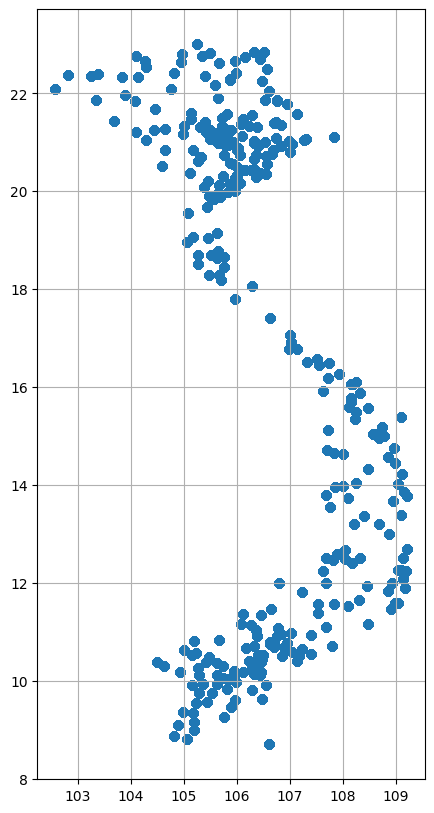

In [ ]:
plt.figure(figsize = (5, 10))
plt.scatter(data[:,0], data[:,1], alpha=0.5)
plt.grid()

In [ ]:
scaler = MinMaxScaler()

data = scaler.fit_transform(data)

In [ ]:
iter = 5
threshold = 1e-7
method = 'euclid'
k = 3

In [ ]:
# Tạo môi trường Spark
conf = SparkConf().setAppName("K-means").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)
rdd = sc.parallelize(data)

In [ ]:
# Hàm tính khoảng cách
def distance(a, b, method):
    if(method == 'euclid'):
      return np.sqrt(np.sum((a - b)**2, axis=1))
    elif(method == 'manhattan'):
      return np.sum(np.abs(a - b), axis=1)
    elif(method == 'cosine'):
      return np.sum(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)), axis=1)

In [ ]:
# Chọn random k điểm dữ liệu từ tập dữ liệu
centroids = np.array(rdd.takeSample(False, k))

In [ ]:
# Hàm áp dụng cho lambda RDD trả về khoảng cách nhỏ nhất từ một điểm đến các tâm cụm
def centroids_to_all(x, centroids):
  dt_list = []
  for i in centroids:
    print(i)
    dt_list.append(distance(np.array([x]), np.array([i]), 'euclid')) 
  return np.min(dt_list)

In [ ]:
# Hàm hiết lập tâm cụm ban đầu nhờ K-means++
def initialize(rdd, k):  
  centroids = np.array(rdd.takeSample(False, 1))

  for i in range(k - 1):
    idx = np.argmax(rdd.map(lambda x: centroids_to_all(x, centroids)).collect())
    centroids = np.vstack((centroids, rdd.collect()[idx]))

  return centroids


In [ ]:
# Hàm áp dụng cho lambda RDD trả về [tâm cụm, khoảng cách] của một điểm đến tâm cụm gần nhất
def function(x, centroids, method):
    dt = distance(x, centroids, method)
    idx = np.argmin(dt)
    return [idx, dt[idx]]

# Hàm phân cụm không gian giữ liệu
def assignment_point(rdd, centroids, method):
    return rdd.map(lambda x: [function(x, centroids, method), x])

# Phân cụm tập dữ liệu
clustered = assignment_point(rdd, centroids, method)
# Tổng các khoảng cách của mỗi đến đến cụm gần nhất tương ứng
total_err = np.sum(np.array(clustered.map(lambda x: x[0][1]).collect()))

In [ ]:
pre_total_err = total_err

for i in range(iter):
     print(f"`iter: {i}`")
     # Tính lại tâm cụm
     centroids=np.array(clustered.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list).map(lambda x: (np.mean(x[1], axis=0))).collect())

     # Phân cụm lại tập giữ liệu
     clustered = assignment_point(rdd, centroids, method)
     total_err = np.sum(clustered.map(lambda x: x[0][1]).collect())

     # Kiểm tra điều kiện dừng
     if(pre_total_err - total_err < threshold or i == iter - 1):
       clustered = clustered.map(lambda x: (x[0][0], x[1])).collect()
       sc.stop()
       print(f"[err: {total_err}]")
       break
     pre_total_err = total_err
     print(f"[err: {total_err}]")

`iter: 0`
[err: 472833.7473657358]
`iter: 1`
[err: 472833.7473657358]


In [ ]:
def kmeans(data, k = 3, method = 'euclid', iter = 100, threshold = 1e-7, mode = 'k-means++'):
  # Tạo môi trường Spark
  conf = SparkConf().setAppName("K-means").setMaster("local[*]")
  sc = SparkContext.getOrCreate(conf)
  rdd = sc.parallelize(data)

  # Chiến thuật chọn tâm cụm ban đầu
  if(mode == 'k-means++'):
    centroids = initialize(rdd, k)
  else:
    centroids = np.array(rdd.takeSample(False, k))

  # Phân cụm tập dữ liệu
  clustered = assignment_point(rdd, centroids, method)
  # Tổng các khoảng cách của mỗi đến đến cụm gần nhất tương ứng
  total_err = np.sum(np.array(clustered.map(lambda x: x[0][1]).collect()))
  pre_total_err = total_err

  for i in range(iter):
      print(f"`iter: {i}`")
      # Tính lại tâm cụm
      centroids=np.array(clustered.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list).map(lambda x: (np.mean(x[1], axis=0))).collect())

      # Phân cụm lại tập dữ liệu
      clustered = assignment_point(rdd, centroids, method)
      total_err = np.sum(clustered.map(lambda x: x[0][1]).collect())

      # Kiểm tra điều kiện dừng
      if(pre_total_err - total_err < threshold or i == iter - 1):
        clustered = clustered.map(lambda x: (x[0][0], x[1])).collect()
        sc.stop()
        print(f"[err: {total_err}]")
        break
      pre_total_err = total_err
      print(f"[err: {total_err}]")
    
  return clustered, centroids, total_err

In [ ]:
cl, ct, err = kmeans(data, 3, iter = 10)

`iter: 0`
[err: 122246.22278601445]
`iter: 1`
[err: 122141.86805775859]
`iter: 2`
[err: 122141.86805775859]


In [ ]:
cl = np.array(cl)

<ipython-input-26-d0bdff2a4d44>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cl = np.array(cl)


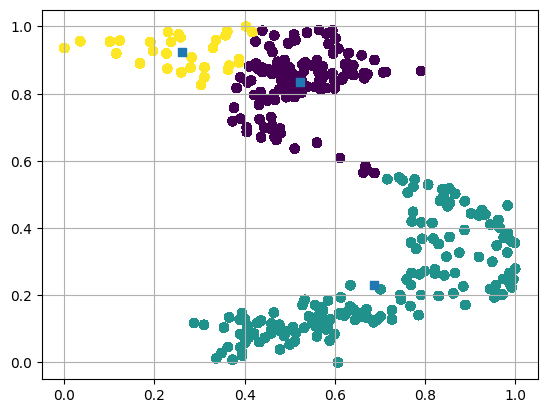

In [ ]:
plt.scatter(np.vstack(cl[:,1])[:, 0], np.vstack(cl[:,1])[:, 1], alpha=0.5, c=cl[:, 0])
plt.scatter(ct[:, 0], ct[:, 1], marker='s')
plt.grid()

In [ ]:
def elbow(data, cluster_range, iter = 20, method = 'euclid', mode='k-means++'):
  # Tạo môi trường Spark
  conf = SparkConf().setAppName("K-means").setMaster("local[*]")
  sc = SparkContext.getOrCreate(conf)
  rdd = sc.parallelize(data)
  # Mảng lưu tổng khoảng cách các lần thử
  err_summary = []

  # Chiến thuật chọn tâm cụm ban đầu
  for i in range(cluster_range):
    print(f"`{i+1} cluster`")
    if(mode == 'k-means++'):
      centroids = initialize(rdd, i+1)
    else:
      centroids = np.array(rdd.takeSample(False, i+1))

    # Phân cụm tập dữ liệu
    clustered = assignment_point(rdd, centroids, method)
    # Tổng các khoảng cách của mỗi đến đến cụm gần nhất tương ứng
    total_err = np.sum(np.array(clustered.map(lambda x: x[0][1]).collect()))
    pre_total_err = total_err

    for k in range(iter):
      # Tính lại tâm cụm
      centroids = np.array(clustered.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list).map(lambda x: (np.mean(x[1], axis=0))).collect())
      # Phân cụm lại tập dữ liệu
      clustered = assignment_point(rdd, centroids, method)
      total_err = np.sum(clustered.map(lambda x: x[0][1]).collect())
    err_summary.append(total_err)
    print(f"[err: {total_err}]")
  del(centroids)
  sc.stop()

  # Vẽ biểu đồ đánh giá
  plt.scatter(np.arange(1, cluster_range + 1, 1), err_summary)
  plt.plot(np.arange(1, cluster_range + 1, 1), err_summary)
  plt.grid()
  plt.show()

In [ ]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import numpy as np
import matplotlib.pyplot as plt

class kmeans():
  # Hàm khởi tạo
  def __init__(self, method = "euclid", iter = 100, threshold = 1e-7, mode = 'k-means++'):
    if method in ['euclid',  'manhattan', 'cosine']:
      self.method = method
    else:
      raise ValueError("Method should be 'euclid', 'manhattan', 'cosine'.")

    if isinstance(iter, int) and iter > 0:
      self.iter = iter
    else:
      raise ValueError("Iter should be an interger great than 0.")

    if isinstance(threshold, str):
      raise ValueError("Threshold should be a float.")
    else:
      self.threshold = threshold

    if mode in ['k-means++','k-means']:
      self.mode = mode
    else:
      raise ValueError("Two mode 'k-means' and 'k-means++'.")
    pass
  
  # Hàm thiết lập phương pháp tính khoảng cách
  def set_method(self, method):
    if method in ['euclid',  'manhattan', 'cosine']:
      self.method = method
    else:
      raise ValueError("Method should be 'euclid', 'manhattan', 'cosine'.")

  # Hàm thiết lập số lần lặp tối đa
  def max_iter(self, iter):
    if isinstance(iter, int) and iter > 0:
      self.iter = iter
    else:
      raise ValueError("Iter should be an interger great than 0.")

  # Hàm thiết lập ngưỡng điều kiện dừng
  def set_threshold(self, threshold):
    if isinstance(threshold, str):
      raise ValueError("Threshold should be a float.")
    else:
      self.threshold = threshold

  # Hàm thiết lập chiến thuật chọn tâm cụm ban đầu
  def set_mode(self, mode):
    if mode in ['k-means++','k-means']:
      self.mode = mode
    else:
      raise ValueError("Two mode 'k-means' and 'k-means++'.")

  # Hàm xác định phương pháp chuẩn hóa
  def scalered(self, method):
    if method == 'minmax':
      return MinMaxScaler()
    else:        
      return StandardScaler()

  # Hàm khôi phục dữ liệu đã chuẩn hóa
  def inverse_transform(self):
    conf = SparkConf().setAppName("K-means").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    self.clustered = sc.parallelize(self.clustered).map(lambda x: [x[0], self.scaler.inverse_transform(np.array([x[1]]))]).collect()
    self.centroids = self.scaler.inverse_transform(self.centroids)
    sc.stop()
  
  # Hàm tính khoảng cách
  def distance(self, a, b):
    if(self.method == 'euclid'):
      print(np.argmin(np.sqrt(np.sum((a - b)**2, axis=1))))
      return np.sqrt(np.sum((a - b)**2, axis=1))
    elif(self.method == 'manhattan'):
      return np.sum(np.abs(a - b), axis=1)
    else:
      return np.sum(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)), axis=1)
  
  # Hàm áp dụng cho lambda RDD trả về [tâm cụm, khoảng cách] của một điểm đến tâm cụm gần nhất
  def function(self, x):
    dt = self.distance(x, self.centroids)
    return [np.argmin(dt), np.min(dt)]

  # Hàm phân cụm không gian dữ liệu
  def assignment_point(self, rdd):
    return rdd.map(lambda x: [self.function(x), x])

  # Hàm áp dụng cho lambda RDD trả về khoảng cách nhỏ nhất từ một diểm đến các tâm cụm
  def centroids_to_all(self, x):
    dt_list = []
    for i in self.centroids:
      dt_list.append(self.distance(np.array([x]), np.array([i]))) 
    return np.min(dt_list)

  # Hàm hiết lập tâm cụm ban đầu nhờ K-means++
  def initialize(self, rdd):
    self.centroids = np.array(rdd.takeSample(False, 1))

    for i in range(self.cluster_num - 1):
      idx = np.argmax(rdd.map(lambda x: self.centroids_to_all(x)).collect())
      self.centroids = np.vstack((self.centroids, rdd.collect()[idx]))
  
  # Hàm tối ưu hóa mô hình
  def fit(self, data, k, scale = False):
    # Chọn phương pháp chuẩn hóa dữ liệu
    if scale:
      method = input('Scale method: ')
      if method in ['minmax', 'std']:
        self.scaler = self.scalered(method)
        data = self.scaler.fit_transform(data)
      else:
        raise ValueError("Two mode 'minmax' and 'std'.")

    self.cluster_num = k
    self.clusters = np.arange(k)

    # Tạo môi trường Spark
    conf = SparkConf().setAppName("K-means").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    rdd = sc.parallelize(data)

    # Chiến thuật chọn tâm cụm ban đầu
    if(self.mode == 'k-means++'):
      self.initialize(rdd)
    else:
      self.centroids = np.array(rdd.takeSample(False, self.cluster_num))

    # Phân cụm tập dữ liệu
    clustered = self.assignment_point(rdd)
    total_err = np.sum(np.array(clustered.map(lambda x: x[0][1]).collect()))
    self.total_err = total_err

    for i in range(self.iter):
      print(f"`iter: {i}`")
      # Tính lại tâm cụm
      self.centroids = np.array(clustered.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list).map(lambda x: (np.mean(x[1], axis=0))).collect())
      # Phân cụm lại tập dữ liệu
      clustered = self.assignment_point(rdd)
      total_err = np.sum(clustered.map(lambda x: x[0][1]).collect())

      # Kiểm tra điều kiện dừng
      if(self.total_err - total_err < self.threshold or i == self.iter - 1):
        self.total_err = total_err
        self.clustered = clustered.map(lambda x: (x[0][0], x[1])).collect()
        sc.stop()
        print(f"[err: {total_err}]")
        break
      self.total_err = total_err
      print(f"[err: {total_err}]")

  # Hàm dự đoán điểm dữ liệu mới
  def predict(self, data, scale = False):
    if scale:
      data = self.scaler.fit_transform(data)

    conf = SparkConf().setAppName("K-means").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    result = sc.parallelize(data).map(lambda x: self.function(x)).map(lambda x: [self.clusters[x[0]], x[1]]).collect()
    sc.stop()
    return result

  # Hàm thay đổi nhãn dữ liệu
  def transform(self, label):
    if(len(label) != self.cluster_num):
      raise ValueError(f"Model has {self.cluster_num} clusters!")
    conf = SparkConf().setAppName("K-means").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)

    self.clusters = label
    self.clustered = sc.parallelize(self.clustered).map(lambda x: [self.clusters[x[0]], x[1]]).collect()
    sc.stop()
  
  # Hàm đánh giá elbow
  def elbow(self, data, cluster_range, iter = 20, scale = False):
    # Chọn phương pháp chuẩn hóa dữ liệu
    if scale:
      method = input('Scale method: ')
    if method in ['minmax', 'std']:
      self.scaler = self.scalered(method)
      data = self.scaler.fit_transform(data)
    else:
      raise ValueError("Two mode 'minmax' and 'std'.")

    # Tạo môi trường Spark
    conf = SparkConf().setAppName("K-means").setMaster("local[*]")
    sc = SparkContext.getOrCreate(conf)
    rdd = sc.parallelize(data)
    # Mảng lưu tổng khoảng cách các lần thử
    err_summary = []
    
    for i in range(cluster_range):
      print(f"`{i+1} cluster`")

      # Chiến thuật chọn tâm cụm ban đầu
      self.cluster_num = i + 1
      if(self.mode == 'k-means++'):
        self.initialize(rdd)
      else:
        self.centroids = np.array(rdd.takeSample(False, self.cluster_num))

      # Phân cụm tập dữ liệu
      clustered = self.assignment_point(rdd)
      total_err = np.sum(np.array(clustered.map(lambda x: x[0][1]).collect()))
      pre_total_err = total_err

      for k in range(iter):
        # Tính lại tâm cụm
        self.centroids = np.array(clustered.map(lambda x: (x[0][0], x[1])).groupByKey().mapValues(list).map(lambda x: (np.mean(x[1], axis=0))).collect())
        # Phân cụm lại dữ liệu
        clustered = self.assignment_point(rdd)
        total_err = np.sum(clustered.map(lambda x: x[0][1]).collect())
        if total_err - pre_total_err < self.threshold:
          break
        pre_total_err = total_err

      err_summary.append(total_err)
      print(f"[err: {total_err}]")
    del(self.centroids)
    del(self.cluster_num)
    sc.stop()

    # Vẽ biểu đồ đánh giá
    plt.scatter(np.arange(1, cluster_range + 1, 1), err_summary)
    plt.plot(np.arange(1, cluster_range + 1, 1), err_summary)
    plt.grid()
    plt.show()

Scale method: minmax
`1 cluster`
[err: 37725.094927404716]
`2 cluster`
[err: 18356.194603320087]
`3 cluster`
[err: 12569.553156649738]
`4 cluster`
[err: 11527.331344108141]
`5 cluster`
[err: 10404.679036805659]
`6 cluster`
[err: 10237.648644886283]
`7 cluster`
[err: 8384.734334484318]
`8 cluster`
[err: 8000.715763761484]
`9 cluster`
[err: 7239.447278164498]
`10 cluster`
[err: 6872.0962594397]


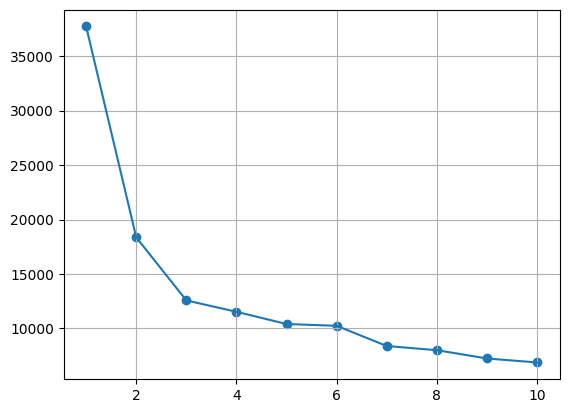

In [ ]:
model = kmeans()
model.elbow(data,10 ,scale = True)

In [ ]:
import time

In [ ]:
model = kmeans()
start = time.time()
model.fit(data, 3, scale = True)
print('time', time.time() - start)

Scale method: minmax
in:  32.52189803123474
`iter: 0`
[err: 12722.350658074702]
`iter: 1`
[err: 12603.805941721579]
`iter: 2`
[err: 12595.781052309801]
`iter: 3`
[err: 12595.781052309801]
time 129.51582074165344


In [ ]:
model.inverse_transform()

In [ ]:
model1 = kmeans()
start = time.time()
model1.fit(data, 5, True)
print('time', time.time() - start)

Scale method: minmax
`iter: 0`
[err: 10838.90468436085]
`iter: 1`
[err: 10360.191250890011]
`iter: 2`
[err: 10282.803713501127]
`iter: 3`
[err: 10263.075063110336]
`iter: 4`
[err: 10254.378567584408]
`iter: 5`
[err: 10259.902502954017]
time 249.4744725227356


In [ ]:
model1.inverse_transform()

In [ ]:
model2 = kmeans()
start = time.time()
model2.fit(data, 7, True)
print('time', time.time() - start)

Scale method: minmax
`iter: 0`
[err: 8634.349952576733]
`iter: 1`
[err: 8044.835997151542]
`iter: 2`
[err: 7894.00623236777]
`iter: 3`
[err: 7860.833307593473]
`iter: 4`
[err: 7870.946888555423]
time 348.05191016197205


In [ ]:
model2.inverse_transform()

In [ ]:
y1 = np.array(model.clustered)
ct1 = np.array(model.centroids)
y2 = np.array(model1.clustered)
ct2 = np.array(model1.centroids)
y3 = np.array(model2.clustered)
ct3 = np.array(model2.centroids)

<ipython-input-15-8c7519591795>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y1 = np.array(model.clustered)
<ipython-input-15-8c7519591795>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y2 = np.array(model1.clustered)
<ipython-input-15-8c7519591795>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y3 = np.array(model2.cluster

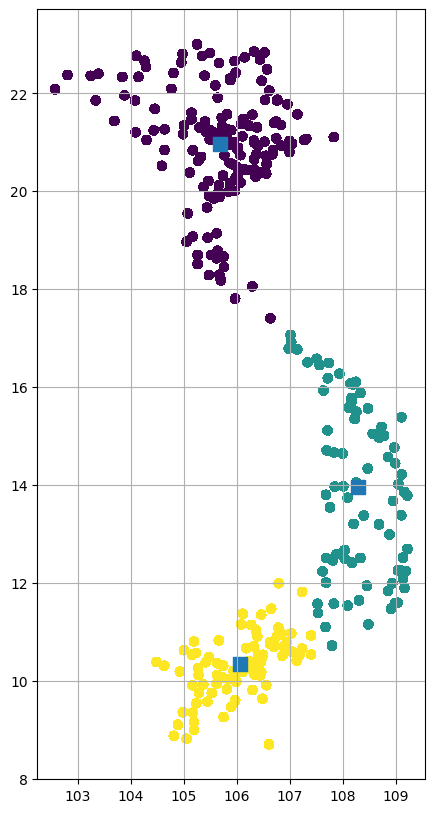

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,10))
plt.scatter(np.vstack(y1[:, 1])[:, 0], np.vstack(y1[:, 1])[:, 1], c = y1[:, 0], alpha = 0.5)
plt.scatter(ct1[:, 0], ct1[:, 1], marker='s', s=100)
plt.grid()

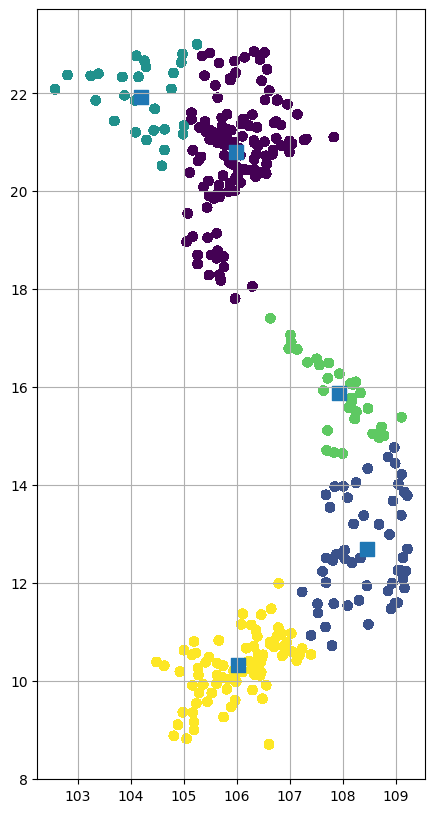

In [ ]:
plt.figure(figsize=(5,10))
plt.scatter(np.vstack(y2[:, 1])[:, 0], np.vstack(y2[:, 1])[:, 1], c = y2[:, 0], alpha = 0.5)
plt.scatter(ct2[:, 0], ct2[:, 1], marker='s', s=100)
plt.grid()

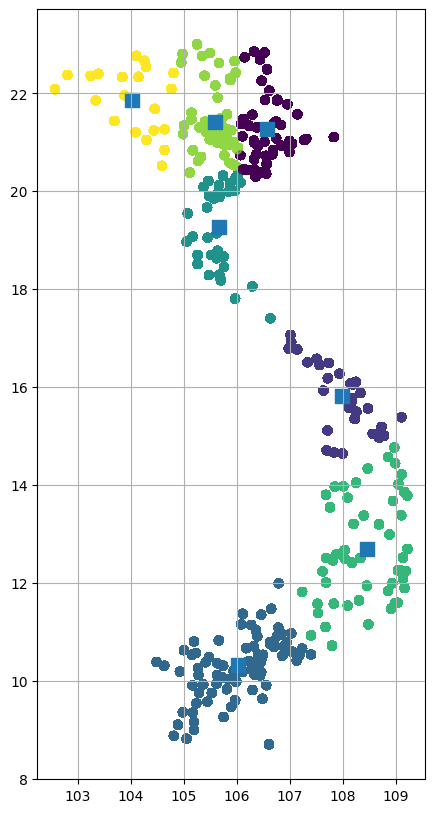

In [ ]:
plt.figure(figsize=(5,10))
plt.scatter(np.vstack(y3[:, 1])[:, 0], np.vstack(y3[:, 1])[:, 1], c = y3[:, 0], alpha = 0.5)
plt.scatter(ct3[:, 0], ct3[:, 1], marker='s', s=100)
plt.grid()

In [ ]:
def locating(model):
  plt.figure(figsize = (5, 10))
  data = np.array(model.clustered)
  plt.scatter(np.vstack(data[:, 1])[:, 0], np.vstack(data[:, 1])[:, 1], c = LabelEncoder().fit_transform(data[:, 0]), alpha = 0.5)
  
  conf = SparkConf().setAppName("K-means").setMaster("local[*]")
  sc = SparkContext.getOrCreate(conf)
  clustered = sc.parallelize(data).groupByKey().mapValues(list).map(lambda x: [x[0], np.vstack(x[1])]).map(lambda x: np.array([np.quantile(x[1][:, 0], 0.25), np.quantile(x[1][:, 0], 0.5), np.quantile(x[1][:, 0], 0.75), np.quantile(x[1][:, 1], 0.25), np.quantile(x[1][:, 1], 0.5), np.quantile(x[1][:, 1], 0.75)])).collect()
  sc.stop()

  for i in clustered:
    x = [i[0], i[0], i[2], i[2], i[0]]
    y = [i[3], i[5], i[5], i[3], i[3]]

    O = [(i[0] + i[2]) / 2, (i[3] + i[5]) / 2]

    plt.fill(x, y, alpha = 0.3)
    plt.scatter(i[1], i[4], s = 100, c='r')
    plt.plot(x, y)
    print(f'Square [[({i[3]}) , ({i[0]})],[({i[5]}) , ({i[0]})],[({i[5]}) , ({i[2]})],[({i[3]}) , ({i[2]})]], dot [({i[4]}) , ({i[1]})]')

  plt.grid()
  plt.show()

<ipython-input-22-f43cd6d4da78>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(model.clustered)


Square [[(20.4388225) , (105.3306814)],[(21.6071636) , (105.3306814)],[(21.6071636) , (106.2992912)],[(20.4388225) , (106.2992912)]], dot [(21.0471807) , (105.7704551)]
Square [[(9.9789961) , (105.4185406)],[(10.7540279) , (105.4185406)],[(10.7540279) , (106.62819010000001)],[(9.9789961) , (106.62819010000001)]], dot [(10.4009358) , (106.22868)]
Square [[(12.2570417) , (107.79915450000001)],[(15.563882499999998) , (107.79915450000001)],[(15.563882499999998) , (108.91456750000002)],[(12.2570417) , (108.91456750000002)]], dot [(13.9645426) , (108.2080973)]


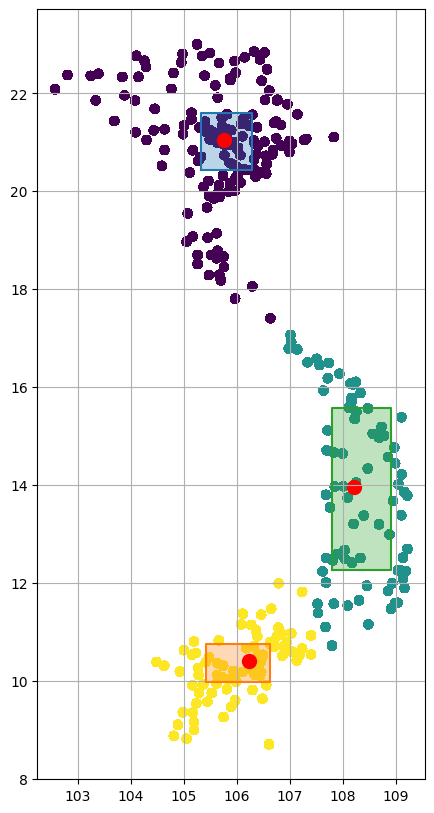

In [ ]:
locating(model)

<ipython-input-22-f43cd6d4da78>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(model.clustered)


Square [[(20.3192475) , (105.6257432)],[(21.3873563) , (105.6257432)],[(21.3873563) , (106.3581527)],[(20.3192475) , (106.3581527)]], dot [(20.9924634) , (105.8804085)]
Square [[(9.9789961) , (105.4185406)],[(10.7480929) , (105.4185406)],[(10.7480929) , (106.62819010000001)],[(9.9789961) , (106.62819010000001)]], dot [(10.381909) , (106.1816196)]
Square [[(21.2648137) , (103.8437852)],[(22.4177717) , (103.8437852)],[(22.4177717) , (104.7695962)],[(21.2648137) , (104.7695962)]], dot [(22.0832638) , (104.2890194)]
Square [[(15.1860945) , (107.56235009999999)],[(16.491213) , (107.56235009999999)],[(16.491213) , (108.2614775)],[(15.1860945) , (108.2614775)]], dot [(15.927263200000002) , (108.0005933)]
Square [[(11.8334154) , (107.85246300000001)],[(13.7399629) , (107.85246300000001)],[(13.7399629) , (109.04532)],[(11.8334154) , (109.04532)]], dot [(12.5049537) , (108.4750846)]


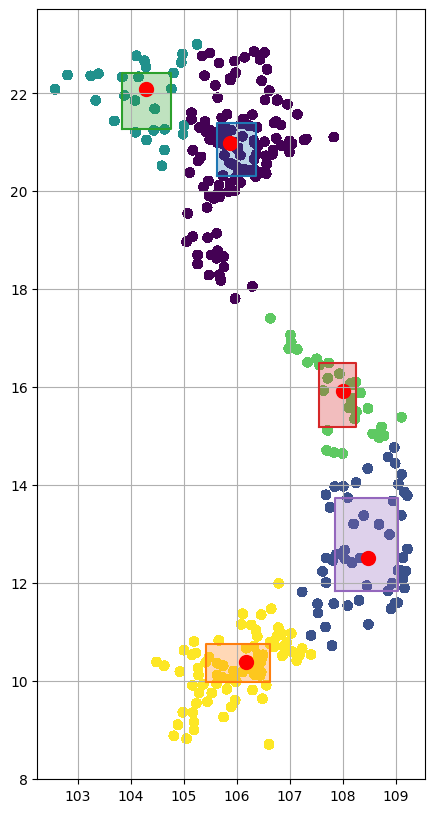

In [ ]:
locating(model1)

<ipython-input-22-f43cd6d4da78>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(model.clustered)


Square [[(20.7526658) , (106.3287199)],[(21.5659824) , (106.3287199)],[(21.5659824) , (106.76917120000002)],[(20.7526658) , (106.76917120000002)]], dot [(21.081585) , (106.52736510000001)]
Square [[(11.8334154) , (107.85246300000001)],[(13.7399629) , (107.85246300000001)],[(13.7399629) , (109.04532)],[(11.8334154) , (109.04532)]], dot [(12.5049537) , (108.4750846)]
Square [[(9.9789961) , (105.4185406)],[(10.7480929) , (105.4185406)],[(10.7480929) , (106.62819010000001)],[(9.9789961) , (106.62819010000001)]], dot [(10.381909) , (106.1816196)]
Square [[(21.2648137) , (103.6927195)],[(22.3750231) , (103.6927195)],[(22.3750231) , (104.4551361)],[(21.2648137) , (104.4551361)]], dot [(21.958688) , (104.1487055)]
Square [[(15.1860945) , (107.6392892)],[(16.4498) , (107.6392892)],[(16.4498) , (108.2614775)],[(15.1860945) , (108.2614775)]], dot [(15.927263200000002) , (108.11421999999999)]
Square [[(20.955835) , (105.348246)],[(21.6071636) , (105.348246)],[(21.6071636) , (105.8480203)],[(20.955

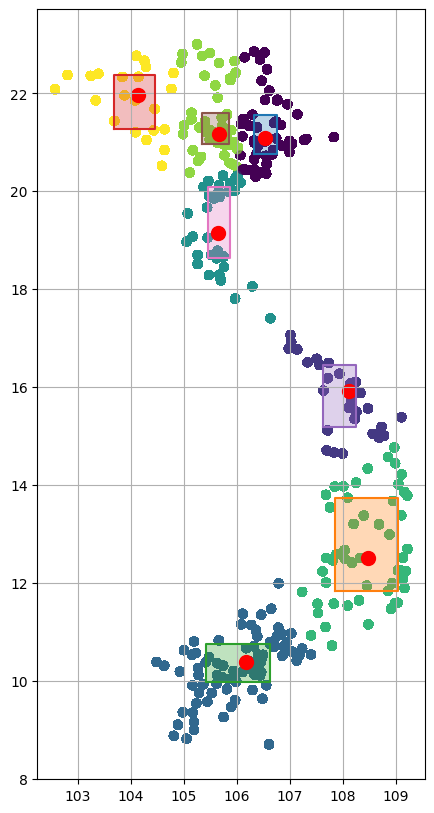

In [ ]:
locating(model2)